In [1]:
#-- Install GroundingDINO for Zero-Shot ---------------------------------------------------------------------
%cd /content/working/

!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd /content/GroundingDINO/
!pip install -e .

!mkdir weights
%cd weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

%cd /content/working/GroundingDINO

#-- clear output --
from IPython import display
display.clear_output()

!python -c "import groundingdino" && echo "Module installed successfully" || echo "Module installation failed"

Module installed successfully


In [3]:
#-- Import -----------------------------------------------------------------------------------------------
%cd /content/GroundingDINO/
from groundingdino.util.inference import load_model as dn_load_model
from groundingdino.util.inference import load_image as dn_load_image
from groundingdino.util.inference import predict as dn_predict
from groundingdino.util.inference import annotate as dn_annotate

import yaml

import torch

import pandas as pd
import numpy as np

import os
import shutil
import PIL
import random
import cv2
import matplotlib.pyplot as plt

/content/GroundingDINO


In [12]:
#-- Initialize -------------------------------------------------------------------
output_path = '/content/working/'
input_path = '/content/input/'

model_config_file = '/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
model_weights_file = '/content/GroundingDINO/weights/groundingdino_swint_ogc.pth'

ds_path = input_path + 'food-101/images/'

dino_imgs_path = output_path + 'dino_results/images/'
dino_lbls_path = output_path + 'dino_results/labels/'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:' , DEVICE)

device: cuda


In [5]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [6]:
# Download data and extract it to folder

get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [7]:
def plot_boxes(image, boxes, logits, phrases):

    annotated_img = dn_annotate(image_source=image,
                                    boxes=boxes,
                                    logits=logits,
                                    phrases=phrases)

    out_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    plt.imshow(out_img, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()


In [8]:
#-- Run DINO and predict Bounding Boxes for Objects ------------------------------------------
def run_dino(model_dino, image, text_prompt='food', box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = dn_predict(
        model = model_dino,
        image = image,
        caption = text_prompt,
        box_threshold = box_threshold,
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

In [9]:
# Load the .txt file and process the contents
file_path = '/content/input/food101_yolo_labels.txt'  # Path to the uploaded file

# Initialize an empty dictionary to store food labels
food_labels = {}

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Each line is in the format: 'label_id:food_name'
        label_id, food_name = line.strip().split(':')
        label_id = int(label_id)  # Convert label_id to an integer
        food_name = food_name.strip("'")  # Remove extra quotes from food_name
        food_labels[label_id] = food_name

# Reverse the dictionary to map food names to label IDs
food_to_label = {name: label for label, name in food_labels.items()}

# Function to get label_id by food_name
def get_label_id(food_name):
    return food_to_label.get(food_name, 0)

In [16]:
#-- Annotate All Images with predicted bounding boxes ------------------------------------
def annotate(dino, image_files, result_imgs_path, result_lbls_path):

    os.makedirs(result_imgs_path, exist_ok=True)
    os.makedirs(result_lbls_path, exist_ok=True)

    i = 1
    for img_file in image_files:

        #-- log --
        if i==1 or i%100==0:
            print(f'annotating {i}th image -------------')

        # Extract the folder name (directory)
        folder_name = os.path.basename(os.path.dirname(img_file))

        # Extract the file name
        file_name_without_extension = os.path.splitext(os.path.basename(img_file))[0]

        result_path = '/content/working/dino_results/labels/' + folder_name+'/'
        label_path = result_path + file_name_without_extension + '.txt'

        directory = os.path.dirname(label_path)

        # Check if directory exists, if not, create it
        if not os.path.exists(directory):
            os.makedirs(directory)

        #img = PIL.Image.open(img_file)
        #img = img.resize((640, 640))
        #img.save(image_path)

        image_source, image = dn_load_image(img_file)
        boxes, logits, phrases = run_dino(dino, image)

        label_id = get_label_id(folder_name)

        label = [str(label_id) + ' ' + ' '.join(list(map(str, b))) for b in boxes.tolist()]
        label = '\n'.join(label)
        if phrases and isinstance(phrases, list) and len(phrases) > 0 and phrases[0] == 'food':
            with open(label_path, 'w') as f:
                f.write(label)
           # if img_file in sampled_images_to_show:
            #    plot_boxes(image_source, boxes, logits, phrases)
        i += 1
        display.clear_output()
        print(i)

In [13]:
#-- Create a dino model --------------------------------------------------------
model_dino = dn_load_model(model_config_file,model_weights_file, device= DEVICE)

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
#-- Get All Images from DS -----------------------------------------------------------
image_files = []
#for root, dirs, files in os.walk(ds_path):
#    for file in files:
#        if file.endswith('.jpg'):
#            image_files.append(os.path.join(root, file))

#total_images = len(image_files)
#print('total_images:' , total_images)


max_images_per_dir = 50  # Maximum number of images to collect from each subdirectory

# Traverse through the directory structure
for root, dirs, files in os.walk(ds_path):
    image_count = 0  # Counter for images in the current subdirectory

    for file in files:
        if file.endswith('.jpg'):
            # Add the image to the list
            image_files.append(os.path.join(root, file))
            image_count += 1

            # Stop once 50 images are added from this subdirectory
            if image_count >= max_images_per_dir:
                break

# Get the total number of images collected
total_images = len(image_files)
print('total_images:', total_images)#


total_images: 5050


In [ ]:
sampled_image_files = random.sample(image_files, 1)
sampled_images_to_show = random.sample(sampled_image_files, 1)

In [17]:
#-- Annotate All Images --------------------------------------------------------
annotate(dino = model_dino ,
         image_files = image_files,
         result_imgs_path = dino_imgs_path,
         result_lbls_path = dino_lbls_path)

5051


In [18]:
import zipfile

def zip_folder(folder_path, output_zip_path):
    # Create a ZipFile object
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk the folder and add files to the zip archive
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # Add the file to the zip, preserving the folder structure
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Paths
folder_path = '/content/working/dino_results/labels'
output_zip_path = '/content/labels.zip'

# Zip the folder
zip_folder(folder_path, output_zip_path)

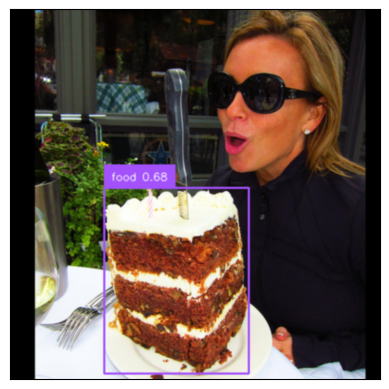

In [29]:
test_img = '/content/input/food-101/images/carrot_cake/867715.jpg'
image_source, image = dn_load_image(test_img)
boxes, logits, phrases = run_dino(model_dino, image)

if phrases and isinstance(phrases, list) and len(phrases) > 0 and phrases[0] == 'food':
    plot_boxes(image_source, boxes, logits, phrases)